In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    implementChainDecayLimit,
    fromHB5Table1,
    readHEPDataCsv,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions
import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
import MassResolutions as resolution


# CMS 13TeV

## `t > H+ b, H+ > W+ H, H > mumu` [1905.07453](https://arxiv.org/abs/1905.07453)

This is a pretty cool limit, sadly there is no usable 2D limit, only one slice with fixed `mH+` and one with `mH+=mA+85GeV`. We can't easily use the latter so we only implement the former.

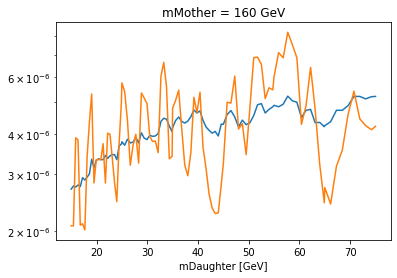

Looks good. Saving this to brtHpb_LHC13_CMS_36.json


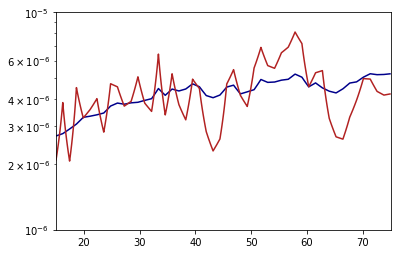

In [2]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1735729/Figure%202b/2/csv"
)
df = dfs[0].rename(
    columns={
        "A boson mass [GeV]": "mDaughter",
        r"Observed upper limit [$\times10^{-6}$]": "obs",
    }
)
df["mMother"] = 160
df["exp"] = dfs[1][r"Expected upper limit [$\times10^{-6}$]"]
df.exp *= 1e-6
df.obs *= 1e-6
limitFile = implementChainDecayLimit(
    "1905.07453",
    {"production": ["brtHpb"], "chain": "W", "decay": ["mumu"]},
    "https://doi.org/10.17182/hepdata.89938.v2/t2",
    df,
    massResolution={
        "daughter": {"absolute": 0, "relative": 1e-2},  # from Tab. 1
        "mother": {
            "absolute": 30,
            "relative": 0,
        },  # they say it's poor (p.1), so guess +-15
    },
    constraints={"mother": [{"topDecayConsistency": ["brtHpb"]}]},
)

lim = HB.Limit(limitFile)

pred = Predictions()
hp = pred.addParticle(HP.ChargedScalar("hp"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hp.setDecayWidth("W", "h1", 1.0)
h1.setDecayWidth("mumu", 1.0)
hp.setMass(160)
hm = np.linspace(15, 75)
r = np.linspace(1e-6, 1e-5)


def testAgainstLimit(mass, rate):
    h1.setMass(mass)
    hp.setCxn("LHC13", "brtHpb", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
